In [1]:
!date

Sat Feb 20 09:09:21 PST 2016


In [8]:
%matplotlib inline

from __future__ import division, print_function

import theano
import numpy as np
import matplotlib.pyplot as plt

from time import time
from theano import tensor, function, shared

In [3]:
N = 1000

In [9]:
# Variable definitions
a = 0.05 # Learning rate
X = tensor.matrix('X') # Data locations
G = tensor.matrix('Y') # Grid point locations
M = shared(np.zeros(int(0.3 * N))) # Vector of priors
theta = shared(np.random.rand(int(0.3 * N))) # Latent Gaussian variables
y = tensor.vector('y') # Observations
scale = tensor.scalar('scale') # Distance scale in Mahalanobis distance
sigma_o = shared(20 * np.random.rand()) # Variance of data
sigma_p = shared(20 * np.random.rand()) # Variance of LGP

# Construct kernel weight matrix
K = tensor.sum(tensor.square(tensor.reshape(X, [-1, 1, 2]) - G) / (4 * tensor.square(scale)), -1)
norms = tensor.reshape(tensor.sum(K, axis=-1), [-1, 1])
row_norms = tensor.cast(tensor.eq(norms, tensor.zeros_like(norms)), 'float32') + norms
K_norm = K / norms

# Construct the likelihoods + priors
likelihood_obs = (-0.5 * tensor.log(2 * np.pi) -
                  tensor.log(sigma_o) -
                  tensor.sum(tensor.square(y - tensor.dot(K_norm, theta)) / (2 * tensor.square(sigma_o))))
param_prior = (-0.5 * tensor.log(2 * np.pi) -
                     tensor.log(sigma_p) -
                     tensor.sum(tensor.square(M - theta) / (2 * tensor.square(sigma_p))))
full_likelihood = -1 * (likelihood_obs + param_prior)

# Compute the gradients
gtheta, gsigma_o, gsigma_p = tensor.grad(full_likelihood, [theta, sigma_o, sigma_p])

# The MAP estimator
likelihood = function(inputs=[X, G, y, scale],
                      outputs=[full_likelihood, theta, sigma_o, sigma_p],
                      updates=[(theta, theta - a * gtheta),
                               (sigma_o, sigma_o - a * gsigma_o),
                               (sigma_p, sigma_p - a * gsigma_p),
                               (M, theta)])

In [10]:
rs = np.random.RandomState(20160219)
X, G, y, scale = (100 * rs.rand(N, 2),
                  100 * rs.rand(int(0.3 * N), 2),
                  rs.randint(10, size=N), 2)

In [11]:
for batch_size in np.unique(np.logspace(1, 3).astype(int)):
    print('Testing batch size: {}'.format(batch_size))
    
    batches = int(X.shape[0] / 1000) + 1
    ll, so, sp = np.empty((100, batches)), np.empty((100, batches)), np.empty((100, batches))
    t = np.empty((100, batches, int(0.3 * N)))
    times = []

    for epoch in range(100):
        t0 = time()
        for i, (mini_batch_x, mini_batch_y) in enumerate(zip(np.array_split(X, batches), np.array_split(y, batches))):
            ll[epoch, i], t[epoch, i, :], so[epoch, i], sp[epoch, i] = likelihood(mini_batch_x, G, mini_batch_y, scale)
        times.append((time() - t0) / 60)
    
    print('Mean batch training time: {}'.format(np.mean(times)))

Testing batch size: 10
Mean batch training time: 8.94336700439e-05
Testing batch size: 12
Mean batch training time: 8.74028205872e-05
Testing batch size: 13
Mean batch training time: 8.59162807465e-05
Testing batch size: 14
Mean batch training time: 8.68646701177e-05
Testing batch size: 15
Mean batch training time: 8.53598515193e-05
Testing batch size: 17
Mean batch training time: 8.75616868337e-05
Testing batch size: 19
Mean batch training time: 8.63311688105e-05
Testing batch size: 21
Mean batch training time: 8.76487890879e-05
Testing batch size: 23
Mean batch training time: 9.14485454559e-05
Testing batch size: 25
Mean batch training time: 8.7459286054e-05
Testing batch size: 28
Mean batch training time: 9.23777023951e-05
Testing batch size: 30
Mean batch training time: 8.78578821818e-05
Testing batch size: 33
Mean batch training time: 8.77496798833e-05
Testing batch size: 37
Mean batch training time: 8.53374401728e-05
Testing batch size: 40
Mean batch training time: 8.64307085673e

(array([ 47.,  45.,   8.,   0.,   0.,   0.,   0.,  11.,  44.,  45.]),
 array([ 13.29625907,  13.30084571,  13.30543235,  13.31001899,
         13.31460563,  13.31919226,  13.3237789 ,  13.32836554,
         13.33295218,  13.33753882,  13.34212545]),
 <a list of 10 Patch objects>)

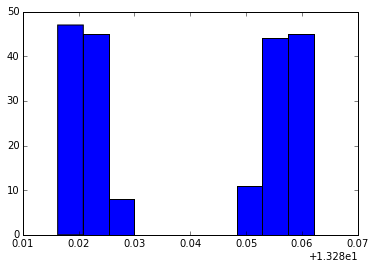

In [12]:
plt.hist(ll[np.where(np.isfinite(ll))])

(array([ 20.,  20.,  20.,  20.,  19.,  20.,  20.,  20.,  20.,  21.]),
 array([ 62.23161957,  62.2523477 ,  62.27307584,  62.29380397,
         62.3145321 ,  62.33526023,  62.35598836,  62.37671649,
         62.39744463,  62.41817276,  62.43890089]),
 <a list of 10 Patch objects>)

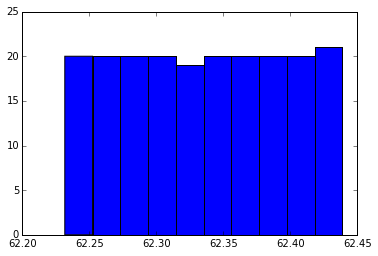

In [13]:
plt.hist(so[np.where(np.isfinite(so))])

(array([ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.]),
 array([ 492.50210854,  492.5041288 ,  492.50614905,  492.50816931,
         492.51018956,  492.51220981,  492.51423007,  492.51625032,
         492.51827058,  492.52029083,  492.52231109]),
 <a list of 10 Patch objects>)

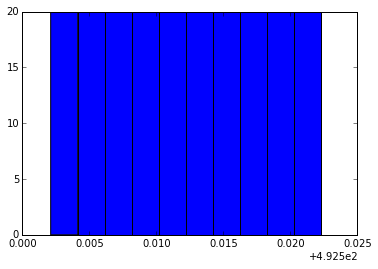

In [14]:
plt.hist(sp[np.where(np.isfinite(sp))])

(array([ 8993.,  8104.,  9201.,  6474.,  7867.,  9161.,  6318.,  2051.,
          831.,  1000.]),
 array([ 0.56520228,  0.76104915,  0.95689602,  1.1527429 ,  1.34858977,
         1.54443664,  1.74028351,  1.93613038,  2.13197725,  2.32782412,
         2.52367099]),
 <a list of 10 Patch objects>)

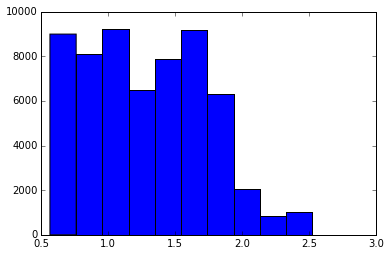

In [15]:
plt.hist(t[np.where(np.isfinite(t))])